In [1]:
import os
import pandas as pd
import seaborn as sns
import random
from datetime import date
from dateutil.relativedelta import relativedelta
from math import floor

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error, confusion_matrix, plot_confusion_matrix, accuracy_score


In [2]:
# Based on:
# Lecture notes from Prof. Burc Ulengin
# This blog post: https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

In [3]:
data_folder = '../03.clean-data/'
results_folder = '../04.results/'
positive_monthly_return_cutoff = 0.002

In [4]:
if not os.path.isdir(results_folder):
    if not os.path.exists(results_folder):
        os.mkdir(results_folder)
    else:
        raise NotADirectoryError

## Load Data

In [5]:
hpi = pd.read_csv(os.path.join(data_folder, 'hpi.csv'), parse_dates=['Date']) # Load
hpi.sort_values(['Area', 'Type', 'Date'], inplace=True) # Sort
hpi.reset_index(inplace=True)

## Check for Stationarity

In [6]:
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
# The p-values are obtained through regression surface approximation from MacKinnon 1994, but using the updated 2010 tables. If the p-value is close to significant, then the critical values should be used to judge whether to reject the null.

In [7]:
# Null Hypothesis of Augmented Dickey-Fuller test: series is non-stationary.
# So, if the p value is less than 0.05, we will reject that the series are non-stationary, and conclude that they are stationary.
# If we fail to reject (p > 0.05) then we fail to reject that the series is non-stationary.
# So we think that the the series is non-stationary if p > 0.05
def is_stationary(x, p=0.05, **kwargs):
    return (adfuller(x, **kwargs)[1] < p)
is_panel_stationary = hpi[hpi['HPI'].notnull()].groupby(['Area', 'Type'])['HPI'].apply(is_stationary)
is_panel_stationary

Area                    Type                  
Adjala-Tosorontio       Composite                 False
                        Single-Family Detached    False
Ajax                    Apartment                 False
                        Composite                 False
                        Single-Family Attached    False
                                                  ...  
Whitchurch-Stouffville  Apartment                  True
                        Composite                 False
                        Single-Family Attached    False
                        Single-Family Detached    False
                        Townhouse                 False
Name: HPI, Length: 286, dtype: bool

In [8]:
is_panel_stationary.sum() / len(is_panel_stationary)

0.006993006993006993

In [9]:
# We have evidence that over 99% of the series are non-stationary.
# This is the statistical reason for the need use either returns or differences.

## Calculate Monthly Changes ("Returns")

In [10]:
hpi_returns = hpi.copy()

In [11]:
hpi_returns['HPI.L1'] = hpi_returns.groupby(['Area', 'Type'])['HPI'].shift(1)
hpi_returns['HPI.F2'] = hpi_returns.groupby(['Area', 'Type'])['HPI'].shift(-2)
hpi_returns['HPI.F5'] = hpi_returns.groupby(['Area', 'Type'])['HPI'].shift(-5)
hpi_returns['MonthlyChangeInHPI'] = (hpi_returns['HPI'] - hpi_returns['HPI.L1']) / hpi_returns['HPI.L1']
hpi_returns['FutureQuarterlyChangeInHPI'] = (hpi_returns['HPI.F2'] - hpi_returns['HPI.L1']) / hpi_returns['HPI.L1']
hpi_returns['FutureSemiAnnualChangeInHPI'] = (hpi_returns['HPI.F5'] - hpi_returns['HPI.L1']) / hpi_returns['HPI.L1']
hpi_returns['PositiveMonthlyReturn'] = (hpi_returns['MonthlyChangeInHPI'] > positive_monthly_return_cutoff)

## Check for Stationarity in Returns

In [12]:
is_panel_stationary = hpi_returns[hpi_returns['MonthlyChangeInHPI'].notnull()].groupby(['Area', 'Type'])['MonthlyChangeInHPI'].apply(is_stationary)
is_panel_stationary

Area                    Type                  
Adjala-Tosorontio       Composite                 True
                        Single-Family Detached    True
Ajax                    Apartment                 True
                        Composite                 True
                        Single-Family Attached    True
                                                  ... 
Whitchurch-Stouffville  Apartment                 True
                        Composite                 True
                        Single-Family Attached    True
                        Single-Family Detached    True
                        Townhouse                 True
Name: MonthlyChangeInHPI, Length: 286, dtype: bool

In [13]:
is_panel_stationary.sum() / len(is_panel_stationary)

0.951048951048951

## Train VAR Model for One Window

In [14]:
window_length = 48  # months before the date we run the forecast on.

In [15]:
# Get a smaller set of panels to avoid non-definite matrices.

city_of_toronto_areas = hpi_returns[hpi_returns['Area'].str.startswith('Toronto')].copy()
no_townhouses = city_of_toronto_areas['Type'] != 'Townhouse'  # Townhouse indices have some data missingness & seem to be prone to noise.
only_composite_indices = city_of_toronto_areas['Type'] == 'Composite'
only_apartment_indices = city_of_toronto_areas['Type'] == 'Apartment'
k = 35  # Setting this too large results in singular matrices and the Cholesky decomposition fails.
panels = city_of_toronto_areas[only_composite_indices].drop_duplicates(['Area', 'Type'])[['Area', 'Type']].sample(n=k)
# panels



In [16]:
feasible_start_dates = pd.date_range(start=city_of_toronto_areas['Date'].min(), 
                       end=city_of_toronto_areas['Date'].max() - relativedelta(months=window_length + 6), 
                       freq='MS')
# Choose a random start date for the window.
start_date = random.choice(feasible_start_dates)
# start_date = pd.to_datetime(date(2015, 1, 1))  # Overwrite the random start date, if needed
start_date

Timestamp('2016-07-01 00:00:00', freq='MS')

In [17]:
end_date = start_date + relativedelta(months=window_length)
train = (
    hpi_returns
        [hpi_returns['Date'].between(start_date, end_date)]
        .merge(panels, on=['Area', 'Type'], how='inner')
        .pivot_table(values=['MonthlyChangeInHPI'], index=['Date'], columns=['Area', 'Type'])
)
train.index = pd.DatetimeIndex(train.index).to_period('M')
date_of_forecasted_value = end_date + relativedelta(months=1)
print(f"Window Start: {start_date}\nWindow End: {end_date}\nDate of the first forecast: {date_of_forecasted_value}")


Window Start: 2016-07-01 00:00:00
Window End: 2020-07-01 00:00:00
Date of the first forecast: 2020-08-01 00:00:00


### Model Training

In [18]:
model = VAR(train)
criterion = {}
models = {}

for lag_order in range(1, window_length):
    try:
        fitted = model.fit(lag_order)
        models[lag_order] = fitted
        criterion[lag_order] = fitted.aic
    except:
        pass
# Next line chooses the model with the lowest AIC value.
selected_lag_order = list(dict(sorted(criterion.items(), key=lambda x:x[1])).keys())[0]
fitted = models[selected_lag_order]

### Model Selection

<AxesSubplot:>

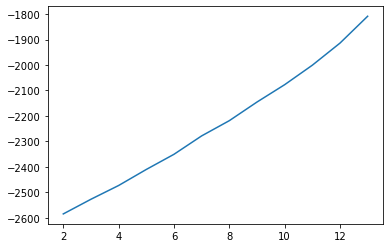

In [19]:
sns.lineplot(x=list(criterion.keys()), y=list(criterion.values()))

In [20]:
import numpy as np
np.linalg.eigvals(fitted.sigma_u)

array([-1.06267901e-30, -3.41142645e-32, -2.07194149e-32, -1.17775877e-32,
       -6.96697337e-33, -6.35834081e-33, -4.00655969e-33, -3.57493594e-33,
       -3.07980919e-33, -2.36866681e-33, -1.95726217e-33, -1.71856835e-33,
       -1.21935938e-33, -1.17648602e-33, -1.07777155e-33, -8.81639788e-34,
       -7.17704307e-34, -5.96374358e-34, -5.44582017e-34, -4.66854568e-34,
       -4.11414863e-34, -3.50773581e-34, -3.19832104e-34, -2.63534436e-34,
       -2.49150413e-34, -1.74601828e-34, -1.36599567e-34, -1.13803898e-34,
       -1.04541829e-34, -7.67484907e-35, -6.39947982e-36, -1.40660860e-35,
       -3.07730048e-35, -5.12848366e-35, -4.36681116e-35])

### Forecasting

In [21]:
steps = 6
forecast = pd.DataFrame(
    columns=train.columns, 
    index=pd.DatetimeIndex(pd.date_range(start=date_of_forecasted_value, periods=steps, freq='MS')), 
    data=fitted.forecast(y=train.values[-selected_lag_order:], steps=steps))
forecast

MonthlyChangeInHPI                                                  \
Area              Toronto C01 Toronto C02 Toronto C03 Toronto C04 Toronto C06   
Type                Composite   Composite   Composite   Composite   Composite   
2020-08-01           0.018077    0.037907    0.006496   -0.023455   -0.003857   
2020-09-01          -0.012920    0.021731   -0.059533   -0.014261    0.030822   
2020-10-01           0.021814   -0.097253   -0.023528    0.032372    0.024306   
2020-11-01          -0.043502   -0.059912    0.016334    0.006038    0.004952   
2020-12-01           0.018032    0.055501    0.028345   -0.043076   -0.049045   
2021-01-01          -0.021808    0.075184    0.010216   -0.028980   -0.011033   

                                                                        ...  \
Area       Toronto C07 Toronto C08 Toronto C09 Toronto C10 Toronto C11  ...   
Type         Composite   Composite   Composite   Composite   Composite  ...   
2020-08-01   -0.004479    0.029505    0.002579    0.071037   -0.046650  ...   
2020-09-01    0.008547   -0.008424   -0.038526   -0.014409   -0.020473  ...   
2020-10-01    0.026516   -0.027184   -0.028714   -0.011586    0.020978  ...   
2020-11-01    0.012358   -0.001762   -0.019859   -0.071907    0.026619  ...   
2020-12-01   -0.027557   -0.016673   -0.000457    0.046075    0.007518  ...   
2021-01-01   -0.013319    0.029306    0.050822    0.053034   -0.028429  ...   

                                                                        \
Area       Toronto W01 Toronto W02 Toronto W03 Toronto W04 Toronto W05   
Type         Composite   Composite   Composite   Composite   Composite   
2020-08-01    0.034419   -0.040035    0.026382   -0.012150   -0.010292   
2020-09-01    0.017471    0.021866   -0.026768   -0.024492    0.010408   
2020-10-01   -0.025351    0.023461   -0.045123   -0.002110    0.016716   
2020-11-01   -0.083591    0.026739    0.005284    0.051072   -0.019562   
2020-12-01   -0.009161   -0.022643    0.027221    0.027445    0.023656   
2021-01-01    0.107433    0.012756    0.034941   -0.001281   -0.021616   

                                                                        
Area       Toronto W06 Toronto W07 Toronto W08 Toronto W09 Toronto W10  
Type         Composite   Composite   Composite   Composite   Composite  
2020-08-01    0.002870   -0.005790    0.011064    0.025773    0.020301  
2020-09-01    0.019621    0.009585   -0.003657   -0.028161    0.010958  
2020-10-01    0.040082    0.009758    0.015275    0.000893   -0.011066  
2020-11-01   -0.011342    0.007011   -0.003729    0.014668    0.008408  
2020-12-01    0.003481   -0.016878   -0.001229    0.012946    0.028679  
2021-01-01    0.000905    0.014593   -0.013335    0.030836   -0.002560  

[6 rows x 35 columns]

In [22]:
forecast_in_tall_fmt = forecast.melt(value_name='ForecastedMonthlyChangeInHPI', ignore_index=False).reset_index().rename(columns={'index': 'Date'})
forecast_in_tall_fmt = forecast_in_tall_fmt[[col for col in forecast_in_tall_fmt.columns if col is not None]]
last_know_hpi_at_the_time_of_forecasting = hpi_returns[hpi_returns['Date'] == end_date].groupby(['Area', 'Type'])[['HPI']].last().reset_index().rename(columns={'HPI': 'LastKnownHPI'})
comparison = (
    city_of_toronto_areas
        [city_of_toronto_areas['Date'].between(start_date, end_date + relativedelta(months=steps))]
        .merge(panels, how='inner', on=['Area', 'Type'])
        .merge(last_know_hpi_at_the_time_of_forecasting, how='left', on=['Area', 'Type'])
        .merge(forecast_in_tall_fmt, how='left', on=['Date', 'Area', 'Type'])
)
comparison.sort_values(['Area', 'Type', 'Date'], inplace=True)
comparison['OnePlusForecastedMonthlyChangeInHPI'] = 1 + comparison['ForecastedMonthlyChangeInHPI']
comparison['OnePlusForecastedCumulativeChangeInHPI'] = comparison.groupby(['Area', 'Type'])['OnePlusForecastedMonthlyChangeInHPI'].cumprod()
comparison['ForecastedHPI'] = comparison['OnePlusForecastedCumulativeChangeInHPI'] * comparison['LastKnownHPI']
comparison.drop(columns=['level_0', 'index'], inplace=True)
random_idx = random.randint(0, len(comparison))
comparison[random_idx:random_idx + 15]

,Area,Date,Type,HPI,HPI.L1,HPI.F2,HPI.F5,MonthlyChangeInHPI,FutureQuarterlyChangeInHPI,FutureSemiAnnualChangeInHPI,PositiveMonthlyReturn,LastKnownHPI,ForecastedMonthlyChangeInHPI,OnePlusForecastedMonthlyChangeInHPI,OnePlusForecastedCumulativeChangeInHPI,ForecastedHPI
960,Toronto E04,2020-02-01,Composite,293.3,288.1,301.4,311.2,0.018049,0.046165,0.080180,True,311.2,NaN,NaN,NaN,NaN
961,Toronto E04,2020-03-01,Composite,300.3,293.3,303.5,315.9,0.023866,0.034777,0.077054,True,311.2,NaN,NaN,NaN,NaN
962,Toronto E04,2020-04-01,Composite,301.4,300.3,302.0,319.1,0.003663,0.005661,0.062604,True,311.2,NaN,NaN,NaN,NaN
963,Toronto E04,2020-05-01,Composite,303.5,301.4,311.2,320.9,0.006967,0.032515,0.064698,True,311.2,NaN,NaN,NaN,NaN
964,Toronto E04,2020-06-01,Composite,302.0,303.5,315.9,320.4,-0.004942,0.040857,0.055684,False,311.2,NaN,NaN,NaN,NaN
965,Toronto E04,2020-07-01,Composite,311.2,302.0,319.1,317.0,0.030464,0.056623,0.049669,True,311.2,NaN,NaN,NaN,NaN
966,Toronto E04,2020-08-01,Composite,315.9,311.2,320.9,323.8,0.015103,0.031170,0.040488,True,311.2,0.001015,1.001015,1.001015,311.515849
967,Toronto E04,2020-09-01,Composite,319.1,315.9,320.4,335.6,0.010130,0.014245,0.062362,True,311.2,-0.009306,0.990694,0.991700,308.616983
968,Toronto E04,2020-10-01,Composite,320.9,319.1,317.0,350.7,0.005641,-0.006581,0.099029,True,311.2,0.012516,1.012516,1.004112,312.479672
969,Toronto E04,2020-11-01,Composite,320.4,320.9,323.8,352.7,-0.001558,0.009037,0.099096,False,311.2,-0.017485,0.982515,0.986555,307.015813


In [23]:
# visualization = comparison.melt(id_vars=['Area', 'Type', 'Date'], value_vars=['HPI', 'ForecastedHPI', 'MonthlyChangeInHPI', 'ForecastedMonthlyChangeInHPI'])
visualization = (
    comparison
        .rename(columns={'HPI': 'ActualHPI'})
        .melt(id_vars=['Area', 'Type', 'Date'], value_vars=['ActualHPI', 'ForecastedHPI'], value_name='HPI', var_name='ActualVsForecasted')
)
last_known_hpi_at_the_time_of_forecasting = visualization[(visualization['Date'] == end_date) & (visualization['ActualVsForecasted'] == 'ActualHPI')].copy()
last_known_hpi_at_the_time_of_forecasting['ActualVsForecasted'] = 'ForecastedHPI'
visualization = pd.concat([visualization, last_known_hpi_at_the_time_of_forecasting])
no_actual_values_for_forecasted_period = ~((visualization['Date'] > end_date) & (visualization['ActualVsForecasted'] == 'ActualHPI'))
visualization

,Area,Type,Date,ActualVsForecasted,HPI
0,Toronto C01,Composite,2016-07-01,ActualHPI,208.3
1,Toronto C01,Composite,2016-08-01,ActualHPI,208.2
2,Toronto C01,Composite,2016-09-01,ActualHPI,212.2
3,Toronto C01,Composite,2016-10-01,ActualHPI,220.6
4,Toronto C01,Composite,2016-11-01,ActualHPI,220.3
...,...,...,...,...,...
1667,Toronto W06,Composite,2020-07-01,ForecastedHPI,254.0
1721,Toronto W07,Composite,2020-07-01,ForecastedHPI,263.7
1775,Toronto W08,Composite,2020-07-01,ForecastedHPI,252.7
1829,Toronto W09,Composite,2020-07-01,ForecastedHPI,286.2


In [24]:
area, housing_type = visualization.sample(1)[['Area', 'Type']].reset_index().loc[0].tolist()[1:]
area = 'Toronto C08'
housing_type = 'Composite'

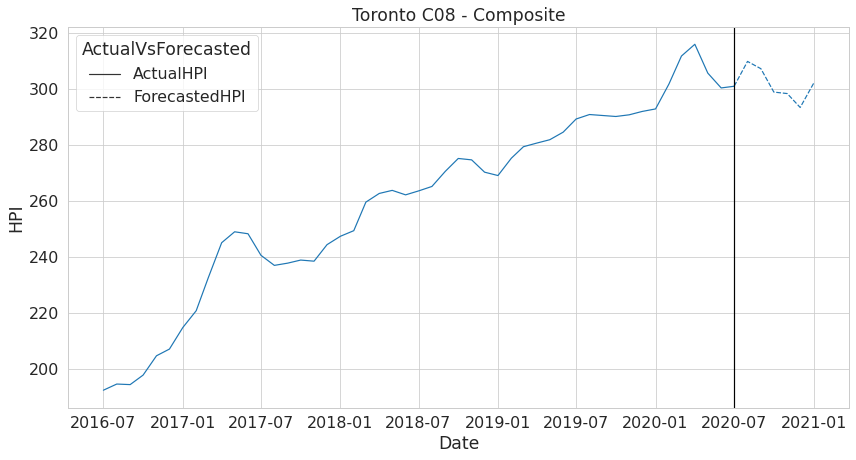

In [25]:

with sns.plotting_context("paper", font_scale=1.8):
    with sns.axes_style("whitegrid"):
        ax = sns.lineplot(
            data=visualization[(visualization['Area'] == area) & (visualization['Type'] == housing_type) & no_actual_values_for_forecasted_period],
            x='Date',
            y='HPI',
            style='ActualVsForecasted',
            estimator='mean'
        )
        ax.figure.set_figwidth(14)
        ax.figure.set_figheight(7)
        ax.axvline(end_date, color='black')
        ax.set_title(f"{area} - {housing_type}")
        fig = ax.get_figure()

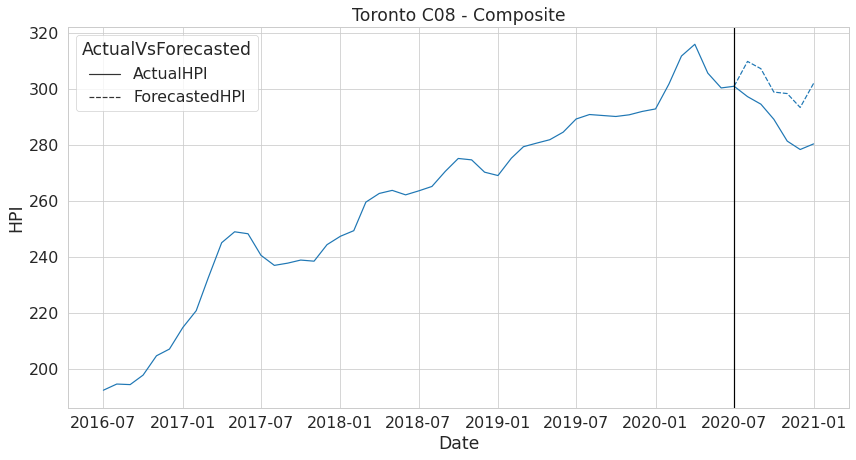

In [26]:

with sns.plotting_context("paper", font_scale=1.8):
    with sns.axes_style("whitegrid"):
        ax = sns.lineplot(
            data=visualization[(visualization['Area'] == area) & (visualization['Type'] == housing_type)],
            x='Date',
            y='HPI',
            style='ActualVsForecasted',
            estimator='mean'
        )
        ax.figure.set_figwidth(14)
        ax.figure.set_figheight(7)
        ax.axvline(end_date, color='black')
        ax.set_title(f"{area} - {housing_type}")
        fig = ax.get_figure()

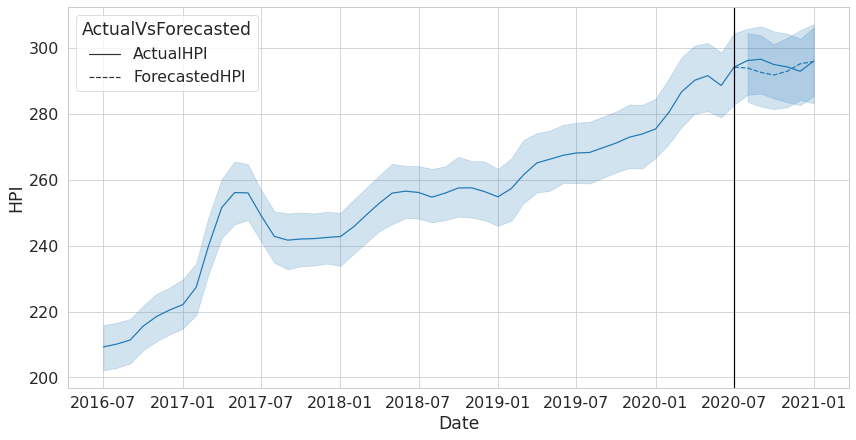

In [27]:
with sns.plotting_context("paper", font_scale=1.8):
    ,
    with sns.axes_style("whitegrid"):
        ax = sns.lineplot(
            data=visualization,
            x='Date',
            y='HPI',
            style='ActualVsForecasted',
            estimator='mean'
        )
        ax.figure.set_figwidth(14)
        ax.figure.set_figheight(7)
        ax.axvline(end_date, color='black')
        fig = ax.get_figure()

## VAR model for all Toronto Meighbourhoods & for all dates.

In [28]:
feasible_start_dates = pd.date_range(start=city_of_toronto_areas['Date'].min(), 
                       end=city_of_toronto_areas['Date'].max() - relativedelta(months=window_length + 6), 
                       freq='MS')

In [29]:
window_length = 48  # months before the date we run the forecast on.

In [30]:
%%time
city_of_toronto_areas = hpi_returns[hpi_returns['Area'].str.startswith('Toronto')].copy()
housing_types = hpi['Type'].unique().tolist()
forecasts = []
for housing_type in housing_types:
    panels = city_of_toronto_areas[city_of_toronto_areas['Type'] == housing_type].drop_duplicates(['Area', 'Type'])[['Area', 'Type']]
    for start_date in feasible_start_dates:
        end_date = start_date + relativedelta(months=window_length)
        train = (
            hpi_returns
                [hpi_returns['Date'].between(start_date, end_date)]
                .merge(panels, on=['Area', 'Type'], how='inner')
                .pivot_table(values=['MonthlyChangeInHPI'], index=['Date'], columns=['Area', 'Type'])
        )
        train.index = pd.DatetimeIndex(train.index).to_period('M')
        
        model = VAR(train)
        criterion = {}
        models = {}

        for lag_order in range(1, window_length):
            try:
                fitted = model.fit(lag_order)
                models[lag_order] = fitted
                criterion[lag_order] = fitted.aic
            except:
                pass
        try:
            # Select the "best" model: model with the lowest AIC value.
            selected_lag_order = list(dict(sorted(criterion.items(), key=lambda x:x[1])).keys())[0]            
            fitted = models[selected_lag_order]
            is_model_selected = True
        except IndexError:
            # No models were trained.
            # This can happen when there is missing data, for instance, with Townhouses.
            is_model_selected = False

        if is_model_selected:
            # TODO: Add quarterly and semiannual forecasts

            monthly_forecast = pd.DataFrame(
                columns=train.columns, 
                index=pd.DatetimeIndex(pd.date_range(start=end_date + relativedelta(months=1), periods=1, freq='MS')), 
                data=fitted.forecast(y=train.values[-selected_lag_order:], steps=1)
            )
            monthly_forecast = monthly_forecast.melt(ignore_index=False).reset_index()
            monthly_forecast = monthly_forecast[[col for col in monthly_forecast.columns if col is not None]]
            monthly_forecast.rename(columns={'value': 'ForecastedMonthlyChangeInHPI', 'index': 'Date'}, inplace=True)
#             monthly_forecast.to_frame(inplace=True)
            
            quarterly_forecast = pd.DataFrame(
                columns=train.columns, 
                index=pd.DatetimeIndex(pd.date_range(start=end_date + relativedelta(months=1), periods=1, freq='MS')), 
                data=(np.matrix(fitted.forecast(y=train.values[-selected_lag_order:], steps=3)) + 1).prod(axis=0) - 1
            )
            quarterly_forecast = quarterly_forecast.melt(ignore_index=False).reset_index()
            quarterly_forecast = quarterly_forecast[[col for col in quarterly_forecast.columns if col is not None]]
            quarterly_forecast.rename(columns={'value': 'ForecastedQuarterlyChangeInHPI', 'index': 'Date'}, inplace=True)
#             quarterly_forecast.to_frame(inplace=True)
            
            semiannual_forecast = pd.DataFrame(
                columns=train.columns, 
                index=pd.DatetimeIndex(pd.date_range(start=end_date + relativedelta(months=1), periods=1, freq='MS')), 
                data=(np.matrix(fitted.forecast(y=train.values[-selected_lag_order:], steps=6)) + 1).prod(axis=0) - 1
            )
            semiannual_forecast = semiannual_forecast.melt(ignore_index=False).reset_index()
            semiannual_forecast = semiannual_forecast[[col for col in semiannual_forecast.columns if col is not None]]
            semiannual_forecast.rename(columns={'value': 'ForecastedSemiAnnualChangeInHPI', 'index': 'Date'}, inplace=True)
#             semiannual_forecast.to_frame(inplace=True)
            
            
            forecast = monthly_forecast.merge(quarterly_forecast, on=['Date', 'Area', 'Type']).merge(semiannual_forecast, on=['Date', 'Area', 'Type'])
            
            
            forecasts.append(forecast)
forecasts = pd.concat(forecasts)
forecasts['ForecastedPositiveReturn'] = forecasts['ForecastedMonthlyChangeInHPI'] > positive_monthly_return_cutoff
forecasts

Wall time: 57.5 s


,Date,Area,Type,ForecastedMonthlyChangeInHPI,ForecastedQuarterlyChangeInHPI,ForecastedSemiAnnualChangeInHPI,ForecastedPositiveReturn
0,2016-03-01,Toronto C01,Apartment,-0.024822,-0.043143,0.010500,False
1,2016-03-01,Toronto C02,Apartment,0.001804,-0.029771,-0.012265,False
2,2016-03-01,Toronto C03,Apartment,-0.076243,0.011991,-0.163622,False
3,2016-03-01,Toronto C04,Apartment,-0.121383,-0.025233,0.027611,False
4,2016-03-01,Toronto C06,Apartment,-0.005403,0.005353,-0.169762,False
...,...,...,...,...,...,...,...
30,2020-11-01,Toronto W06,Single-Family Detached,0.025954,0.035871,-0.037467,True
31,2020-11-01,Toronto W07,Single-Family Detached,0.020134,0.033819,-0.051243,True
32,2020-11-01,Toronto W08,Single-Family Detached,0.029876,0.063618,0.008514,True
33,2020-11-01,Toronto W09,Single-Family Detached,0.021685,0.073601,0.018011,True


In [31]:
len(forecasts), len(forecasts.drop_duplicates(['Area', 'Type', 'Date']))

(7980, 7980)

## Validate

In [32]:
validation = hpi_returns.merge(
    forecasts,
    how='outer',
    on=['Area', 'Type', 'Date'],
)
print(len(validation), len(validation.drop_duplicates(['Area', 'Type', 'Date'])))  # Check if the merge (join) impacted the granularity of the data set, i.e. if we introduced duplicates
validation = validation[validation['ForecastedMonthlyChangeInHPI'].notnull() & validation['MonthlyChangeInHPI'].notnull()]

27225 27225


In [33]:
validation.drop(columns=['level_0', 'index']).to_csv(os.path.join(results_folder, '05.c.var_forecasts.csv'), index=False)

### MSE

In [34]:
mse = mean_squared_error(validation['MonthlyChangeInHPI'], validation['ForecastedMonthlyChangeInHPI'])
mse

0.0015877140296963997

In [35]:
quarterly_change_validation = validation[validation['FutureQuarterlyChangeInHPI'].notnull() & validation['ForecastedQuarterlyChangeInHPI'].notnull()]
quarterly_mse = mean_squared_error(quarterly_change_validation['FutureQuarterlyChangeInHPI'], quarterly_change_validation['ForecastedQuarterlyChangeInHPI'])
quarterly_mse

0.007939166535112235

In [36]:
semi_annual_change_validation = validation[validation['FutureSemiAnnualChangeInHPI'].notnull() & validation['ForecastedSemiAnnualChangeInHPI'].notnull()]
semi_annual_mse = mean_squared_error(semi_annual_change_validation['FutureSemiAnnualChangeInHPI'], semi_annual_change_validation['ForecastedSemiAnnualChangeInHPI'])
semi_annual_mse

0.04461376661958542

### Normalized MSE

In [37]:
mse / hpi_returns['MonthlyChangeInHPI'].mean()

0.1888803247746917

In [38]:
mse / hpi_returns.query('Area == "TREB Total" & Type == "Composite"')['MonthlyChangeInHPI'].mean()

0.2174545814539364

### MSE by Area & Housing Type

In [39]:
benchmark_mse_by_area_and_type = (
    validation
        .groupby(['Area', 'Type'])
        .apply(lambda x: mean_squared_error(x['MonthlyChangeInHPI'], x['ForecastedMonthlyChangeInHPI']))
)
benchmark_mse_by_area_and_type

Area         Type                  
Toronto C01  Apartment                 0.001367
             Composite                 0.000662
             Single-Family Attached    0.002035
             Single-Family Detached    0.003612
Toronto C02  Apartment                 0.002011
                                         ...   
Toronto W09  Single-Family Detached    0.001317
Toronto W10  Apartment                 0.003210
             Composite                 0.000542
             Single-Family Attached    0.000953
             Single-Family Detached    0.000820
Length: 140, dtype: float64

### City of Toronto MSE by Year

In [40]:
validation_for_city_of_toronto = validation[validation['Area'].str.startswith('Toronto')]

benchmark_city_of_toronto_mse_by_year = (
    validation
        .groupby(validation_for_city_of_toronto['Date'].dt.year)
        .apply(lambda x: mean_squared_error(x['MonthlyChangeInHPI'], x['ForecastedMonthlyChangeInHPI']))
)
benchmark_city_of_toronto_mse_by_year

Date
2016    0.001652
2017    0.002495
2018    0.001380
2019    0.000995
2020    0.001360
dtype: float64

## Accuracy Score for the Positive Return Probability

In [41]:
accuracy_score(validation['PositiveMonthlyReturn'].astype(int), validation['ForecastedPositiveReturn'].astype(int))

0.5585459183673469

## Confusion Matrix for the Positive Return Probability

In [42]:
confusion_matrix(validation['PositiveMonthlyReturn'].astype(int), validation['ForecastedPositiveReturn'].astype(int), normalize='pred')

array([[0.44336973, 0.3618123 ],
       [0.55663027, 0.6381877 ]])